In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data

In [3]:
train_dict, train_files = data.get_data('train')

preprocess False
keypoints None
1.17055106163


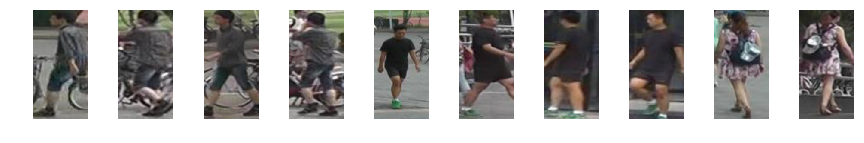

0.0 1.0
1.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
1.0 1.0
0.0 1.0


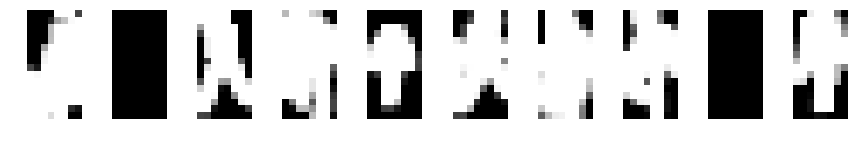

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=8, preprocess=False,
                                    shape=(256,128), keypoints=None, 
                                    cam_output_dim=(16,8), cam_wide=True).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    im = batch[1]['cam_output'][i].squeeze()
    print im.min(), im.max()
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

# file_root = 'densenet_cam_l1_wide'

In [6]:
# if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
#     os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

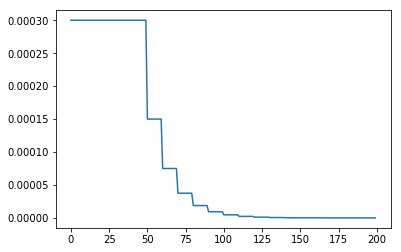

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 4
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=1.0, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 128)

exec(def_triplet_loss)

def cam_loss(y_true, y_pred, P=P_param, K=K_param, cam_dim=(16,8)):
#     return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return Keras.sum(triplet.norm(y_true, y_pred, axis=(1,2), norm=1))
#     return tf.losses.hinge_loss(labels=y_true, logits=y_pred)

In [10]:
trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), weights='imagenet')

Weights for the model were loaded successfully


In [11]:
from keras.layers import Lambda

def cam(im, cam_dim=(16,8)):
    cam_mean = Keras.mean(tf.image.resize_images(im, cam_dim), axis=3)
    cam_min = tf.tile(tf.reshape(Keras.min(cam_mean, axis=(1,2)), (-1, 1, 1)), (1,cam_dim[0],cam_dim[1]))
    cam_mean = cam_mean - cam_min
    cam_max = tf.tile(tf.reshape(Keras.max(cam_mean, axis=(1,2)), (-1, 1, 1)), (1,cam_dim[0],cam_dim[1]))
    cam_norm = tf.div(cam_mean, cam_max)
    return cam_mean

cam_output = Lambda(cam, name='cam_output')(trinet.layers[-6].output)

In [12]:
camnet = Model(inputs=trinet.input, outputs=[trinet.output, cam_output])
camnet.compile(loss=[triplet_loss, cam_loss], loss_weights=[1.0, 0.02],
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [13]:
camnet.output

[<tf.Tensor 'final_output/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'cam_output/sub:0' shape=(?, 16, 8) dtype=float32>]

In [14]:
camnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [15]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.final_output_loss = []
        self.cam_output_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
#         print logs.keys()
        self.loss.append(logs['loss'])
        self.final_output_loss.append(logs['final_output_loss'])
        self.cam_output_loss.append(logs['cam_output_loss'])
    
    def on_train_end(self, logs={}):
        print self.loss, self.final_output_loss, self.cam_output_loss

In [16]:
# model_json = camnet.to_json()
# with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
#     json_file.write(model_json)

In [19]:
camnet.set_weights(np.load('/home/albert/github/tensorflow/models/densenet_cam_l1_test/densenet_cam_l1_test_5000.npy'))

In [20]:
train_score = {}
hist = {'loss' : [], 'final_output_loss' : [], 'cam_output_loss' : []}
history = History()
loss = LossHistory()

In [21]:
for era in range(6,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    camnet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=preprocess,
                                                     shape=input_shape, keypoints=None, cam_wide=False,
                                                     cam_output_dim=(16,8)), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history, loss])
    
#     file_name = file_root + '_' + str(iterations) + '.npy'
#     np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), camnet.get_weights())
    
    train_score[iterations] = evaluation.get_score(camnet, hist=history, preprocess=preprocess)
    
    hist['loss'] += loss.loss
    hist['final_output_loss'] += loss.final_output_loss
    hist['cam_output_loss'] += loss.cam_output_loss
    
    print iterations, train_score[iterations]

preprocess True
keypoints None
Epoch 1/10
100/100 [==============================] - 63s - loss: 51.7077 - final_output_loss: 41.3884 - cam_output_loss: 497.5422    
Epoch 2/10
100/100 [==============================] - 60s - loss: 45.2647 - final_output_loss: 34.7336 - cam_output_loss: 508.0907    
Epoch 3/10
100/100 [==============================] - 59s - loss: 39.3147 - final_output_loss: 28.7745 - cam_output_loss: 508.5064    
Epoch 4/10
100/100 [==============================] - 60s - loss: 34.3717 - final_output_loss: 23.9405 - cam_output_loss: 503.0263    
Epoch 5/10
100/100 [==============================] - 59s - loss: 32.1984 - final_output_loss: 21.7719 - cam_output_loss: 502.7523    
Epoch 6/10
100/100 [==============================] - 60s - loss: 31.9497 - final_output_loss: 21.5651 - cam_output_loss: 500.6182    
Epoch 7/10
100/100 [==============================] - 60s - loss: 39.1336 - final_output_loss: 28.6297 - cam_output_loss: 506.5399    
Epoch 8/10
100/100 [====

100/100 [==============================] - 59s - loss: 16.9239 - final_output_loss: 6.7537 - cam_output_loss: 489.6166    
Epoch 4/10
100/100 [==============================] - 60s - loss: 17.4596 - final_output_loss: 7.1373 - cam_output_loss: 497.2222    
Epoch 5/10
100/100 [==============================] - 59s - loss: 16.3566 - final_output_loss: 6.1187 - cam_output_loss: 493.0033    
Epoch 6/10
100/100 [==============================] - 60s - loss: 15.2126 - final_output_loss: 5.1063 - cam_output_loss: 486.4208    
Epoch 7/10
100/100 [==============================] - 60s - loss: 14.9859 - final_output_loss: 4.8897 - cam_output_loss: 485.9155    
Epoch 8/10
100/100 [==============================] - 60s - loss: 17.3018 - final_output_loss: 7.1384 - cam_output_loss: 489.2744    
Epoch 9/10
100/100 [==============================] - 61s - loss: 18.8308 - final_output_loss: 8.5478 - cam_output_loss: 495.2554    
Epoch 10/10
100/100 [==============================] - 60s - loss: 16.597

KeyboardInterrupt: 

In [24]:
# np.save('/home/albert/history.npy', hist)

In [20]:
train_score[1000] = evaluation.get_score(camnet, hist=None, preprocess=True)
print train_score[1000]

1000 20.8790941238
2000 40.7718970776
3000 60.7450749874
4000 80.6640820503
5000 100.595850945
6000 120.527519941
7000 140.477994919
8000 160.432079077
9000 180.458948135
10000 200.382040977
11000 220.308362961
12000 240.256586075
13000 260.276325941
1000 19.9543418884
2000 40.2368710041
3000 60.5748519897
{'mAP': 0.16550437170020058, 'rank': [0.33818289786223277, 0.5599762470308789, 0.7568289786223278], 'loss': []}


In [20]:
np.savez('/home/albert/history.npz' , hist)
np.savez('/home/albert/score.npz' , train_score)

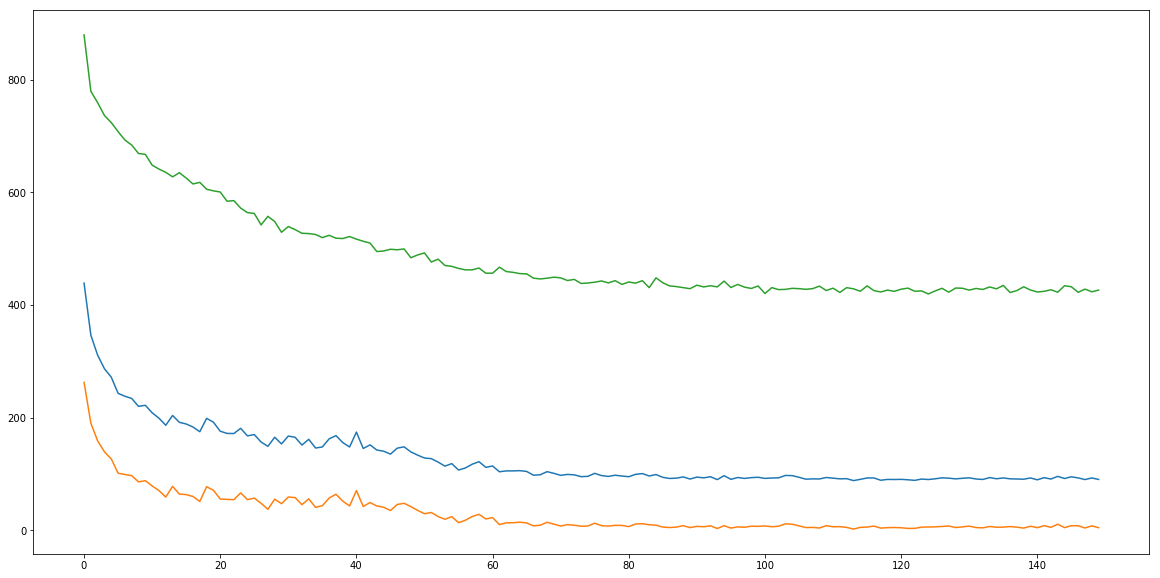

In [21]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(150), hist['loss'], 
         np.arange(150), hist['final_output_loss'], 
         np.arange(150), hist['cam_output_loss'])
plt.show()

In [6]:
hist = np.load('/home/albert/history.npz')['arr_0'].item()

(0.0, 200.0)

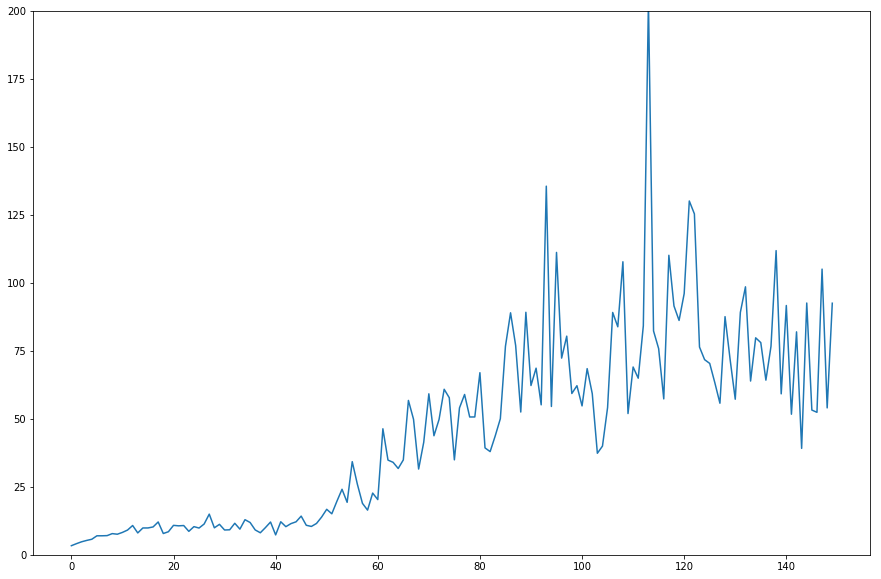

In [9]:
plt.figure(figsize=(15,10))
plt.plot(np.divide(hist['cam_output_loss'], hist['final_output_loss']))
plt.ylim(0.0,200.0)

In [13]:
train_score = np.load('/home/albert/score.npz')['arr_0'].item()

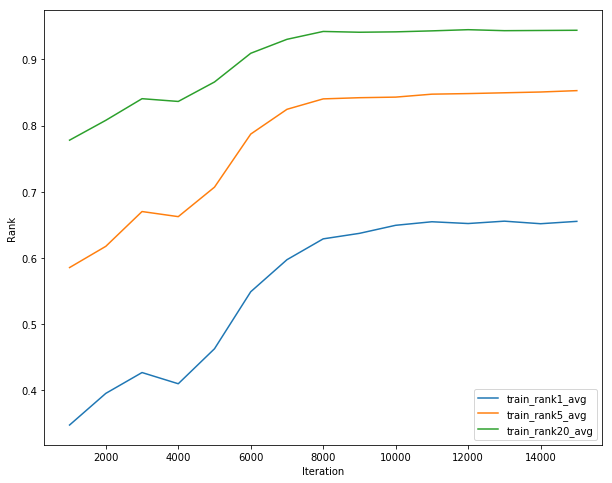

iterations 13000
best_train {1: 0.6555819477434679, 20: 0.94328978622327786, 5: 0.84946555819477432}


In [17]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []

min_iter = np.array(train_score.keys()).min()
max_iter = np.array(train_score.keys()).max()

for it in range(min_iter, max_iter + 1000,1000):
    if type(train_score[it]['rank']) is dict:
        train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][1])))
        train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][5])))
        train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][20])))
    elif type(train_score[it]['rank']) is list:
        train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][0])))
        train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][1])))
        train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][2])))
    else:
        raise TypeError, 'rank container must be list or dict'

plt.figure(figsize=(10,8))
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.legend(loc='lower right')
# plt.title('rank: %s' % model_root)
plt.xlabel('Iteration')
plt.ylabel('Rank')
# plt.ylim(ylim_0,ylim_1)
plt.show()

m = np.array(train_rank1_avg).argmax()
best_train = {1:train_rank1_avg[m], 5:train_rank5_avg[m], 20:train_rank20_avg[m]}

print 'iterations' , 1000 * m + min_iter
print 'best_train' , best_train

In [21]:
base_score = np.load('/home/albert/github/tensorflow/models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_test_score.npz')['arr_0'].item()

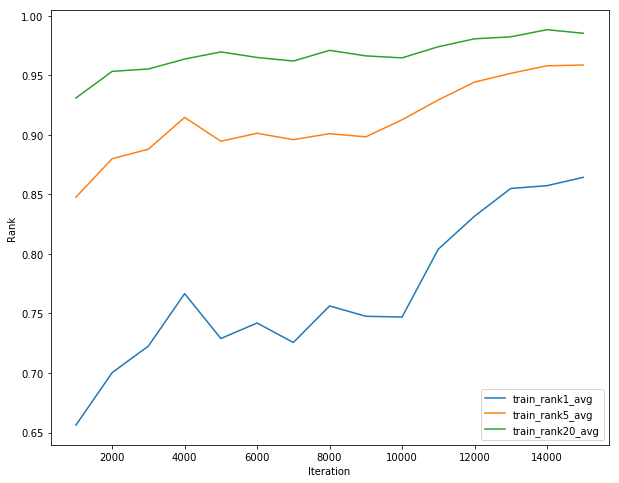

iterations 15000
best_train {1: 0.86433333333333329, 20: 0.98533333333333328, 5: 0.95866666666666667}


In [26]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []

min_iter = 1000
max_iter = 15000

for it in range(min_iter, max_iter + 1000,1000):
#     if type(train_score[it]['rank']) is dict:
    train_rank1_avg.append(np.average(np.array(base_score['rank1'][it])))
    train_rank5_avg.append(np.average(np.array(base_score['rank5'][it])))
    train_rank20_avg.append(np.average(np.array(base_score['rank20'][it])))
#     elif type(train_score[it]['rank']) is list:
#         train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][0])))
#         train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][1])))
#         train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][2])))
#     else:
#         raise TypeError, 'rank container must be list or dict'

plt.figure(figsize=(10,8))
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(min_iter,max_iter+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.legend(loc='lower right')
# plt.title('rank: %s' % model_root)
plt.xlabel('Iteration')
plt.ylabel('Rank')
# plt.ylim(ylim_0,ylim_1)
plt.show()

m = np.array(train_rank1_avg).argmax()
best_train = {1:train_rank1_avg[m], 5:train_rank5_avg[m], 20:train_rank20_avg[m]}

print 'iterations' , 1000 * m + min_iter
print 'best_train' , best_train

In [19]:
from scipy.special import expit
cam = expit(camnet.predict(batch[0]['input_im'][1].reshape((1,256,128,3)))[1][0])

In [20]:
cam.min(), cam.max()

(0.5, 0.7692458)

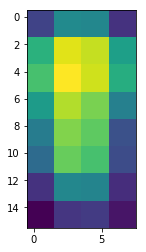

In [21]:
plt.imshow((255 * cam).astype(np.uint8))

In [23]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation

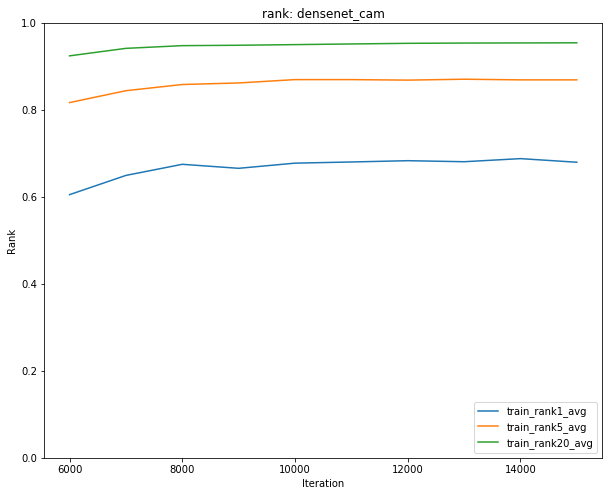

iterations 14000
best_train {1: 0.68794536817102137, 20: 0.95397862232779096, 5: 0.86906175771971494}


In [24]:
evaluation.plot_rank('densenet_cam', ylim_0=0.0)

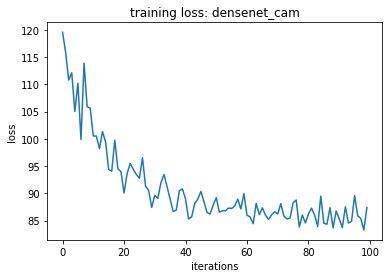

In [25]:
evaluation.plot_loss('densenet_cam')

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)

In [ ]:
camnet.set_weights(np.load('/home/albert/camnet_1000.npy'))

In [18]:
score = evaluation.get_score(camnet, preprocess=True)
print score

1000 21.8936359882
2000 42.7111179829
3000 63.1386070251
4000 83.5858590603
5000 104.019279957
6000 124.397515059
7000 145.134938002
8000 165.543842077
9000 186.446479082
10000 207.014755011
11000 227.91418314
12000 248.811733007
13000 269.319993019
1000 20.5028569698
2000 41.2674229145
3000 62.0226399899
{'mAP': 0.0041801132342738087, 'rank': [0.007422802850356294, 0.022268408551068885, 0.062351543942992874], 'loss': []}


In [21]:
from keras.models import load_model
model = load_model('/home/albert/github/tensorflow/pre/models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_13000.h5', 
                   custom_objects={'triplet_loss' : triplet.triplet_loss})

In [22]:
# base_score = evaluation.get_score(model, preprocess=True)
# print base_score

In [23]:
base_cam = Model(inputs=model.input, outputs=model.layers[-6].output)
base_cam.compile(loss=categorical_crossentropy,
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [40]:
cam_b = base_cam.predict(batch[0]['input_im'][2].reshape((1,256,128,3)))[0]

In [41]:
cam_mean = np.mean(cam_b, axis=2)

In [42]:
print cam_mean.min(), cam_mean.max()

0.310674 0.717329


(array([ 7.,  5.,  3.,  6.,  2.,  3.,  2.,  1.,  2.,  1.]),
 array([ 0.30199209,  0.35869804,  0.415404  ,  0.47210995,  0.52881591,
         0.58552186,  0.64222782,  0.69893377,  0.75563973,  0.81234568,
         0.86905164]),
 <a list of 10 Patch objects>)

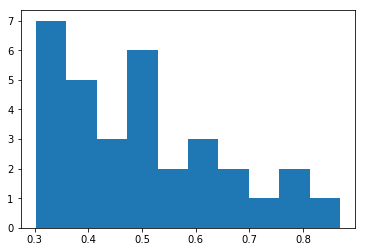

In [28]:
plt.hist(cam_mean.flatten(), bins=10)

In [26]:
cam_norm = cam_mean - cam_mean.min()
cam_norm = cam_norm / cam_norm.max()

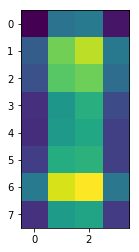

In [27]:
plt.imshow((255 * cam_norm).astype(np.uint8))

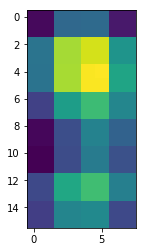

In [64]:
plt.imshow((255 * cam).astype(np.uint8))